<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:10:28] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


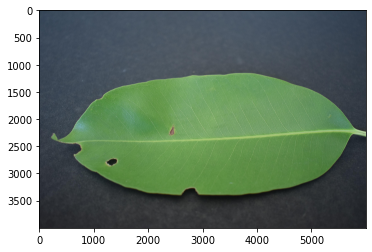

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

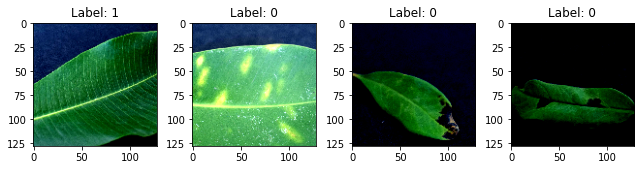

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[16:10:35] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:10:37] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2285581576068167 samples/sec                   batch loss = 0.5302595496177673 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2478558494767693 samples/sec                   batch loss = 0.6613852977752686 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.261641267598887 samples/sec                   batch loss = 0.44166773557662964 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2566780338249297 samples/sec                   batch loss = 0.4670219123363495 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2589726819127194 samples/sec                   batch loss = 0.9364215731620789 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2568762087641734 samples/sec                   batch loss = 1.3763256072998047 | accuracy = 0.5333333333333333


Epoch[1] Batch[35] Speed: 1.2574922208801582 samples/sec                   batch loss = 1.1616055965423584 | accuracy = 0.5357142857142857


Epoch[1] Batch[40] Speed: 1.2555044822511952 samples/sec                   batch loss = 0.45968127250671387 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.257673587942801 samples/sec                   batch loss = 0.7198470830917358 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.250598083360305 samples/sec                   batch loss = 0.5206966996192932 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.2551745075596414 samples/sec                   batch loss = 0.6949362754821777 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.2627653987918643 samples/sec                   batch loss = 0.5964166522026062 | accuracy = 0.5875


Epoch[1] Batch[65] Speed: 1.2505875494308174 samples/sec                   batch loss = 0.5556713342666626 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.2408154619724208 samples/sec                   batch loss = 0.5248737931251526 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2391670115933782 samples/sec                   batch loss = 0.6066582798957825 | accuracy = 0.59


Epoch[1] Batch[80] Speed: 1.2428918016498534 samples/sec                   batch loss = 0.683966875076294 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.265653442794061 samples/sec                   batch loss = 0.346200555562973 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.242657972444116 samples/sec                   batch loss = 0.6122663021087646 | accuracy = 0.6


Epoch[1] Batch[95] Speed: 1.2401886316150519 samples/sec                   batch loss = 0.6244732141494751 | accuracy = 0.5973684210526315


Epoch[1] Batch[100] Speed: 1.2348016000326194 samples/sec                   batch loss = 0.5915239453315735 | accuracy = 0.5925


Epoch[1] Batch[105] Speed: 1.2437451035163352 samples/sec                   batch loss = 0.4218635857105255 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.2556235336310357 samples/sec                   batch loss = 0.46068263053894043 | accuracy = 0.6045454545454545


Epoch[1] Batch[115] Speed: 1.2577865445936454 samples/sec                   batch loss = 0.5748406052589417 | accuracy = 0.6065217391304348


Epoch[1] Batch[120] Speed: 1.2594041984603894 samples/sec                   batch loss = 0.5107526779174805 | accuracy = 0.60625


Epoch[1] Batch[125] Speed: 1.253684504944469 samples/sec                   batch loss = 0.6686173677444458 | accuracy = 0.608


Epoch[1] Batch[130] Speed: 1.2587290803788367 samples/sec                   batch loss = 0.5497666001319885 | accuracy = 0.6096153846153847


Epoch[1] Batch[135] Speed: 1.2603250179896555 samples/sec                   batch loss = 0.596686601638794 | accuracy = 0.6092592592592593


Epoch[1] Batch[140] Speed: 1.2507012879664434 samples/sec                   batch loss = 0.47841355204582214 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2574345412828876 samples/sec                   batch loss = 0.5311461091041565 | accuracy = 0.6275862068965518


Epoch[1] Batch[150] Speed: 1.2606218060795347 samples/sec                   batch loss = 0.9382264614105225 | accuracy = 0.63


Epoch[1] Batch[155] Speed: 1.2527306106835632 samples/sec                   batch loss = 0.5714280009269714 | accuracy = 0.6306451612903226


Epoch[1] Batch[160] Speed: 1.2591156374415058 samples/sec                   batch loss = 0.425863116979599 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.2516319236410658 samples/sec                   batch loss = 0.33957237005233765 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2557268174796838 samples/sec                   batch loss = 0.7347925305366516 | accuracy = 0.6455882352941177


Epoch[1] Batch[175] Speed: 1.2508829396064016 samples/sec                   batch loss = 0.9873152375221252 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2554759207952089 samples/sec                   batch loss = 1.3611969947814941 | accuracy = 0.6472222222222223


Epoch[1] Batch[185] Speed: 1.2513597929707556 samples/sec                   batch loss = 0.6521099805831909 | accuracy = 0.6445945945945946


Epoch[1] Batch[190] Speed: 1.2501738834832374 samples/sec                   batch loss = 0.9838191866874695 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.2580188389213736 samples/sec                   batch loss = 0.19252638518810272 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2556833027406207 samples/sec                   batch loss = 0.5984268188476562 | accuracy = 0.65125


Epoch[1] Batch[205] Speed: 1.2518470045821621 samples/sec                   batch loss = 0.7912716865539551 | accuracy = 0.65


Epoch[1] Batch[210] Speed: 1.2542059689627454 samples/sec                   batch loss = 0.3515397310256958 | accuracy = 0.6488095238095238


Epoch[1] Batch[215] Speed: 1.255904761170443 samples/sec                   batch loss = 0.34815457463264465 | accuracy = 0.65


Epoch[1] Batch[220] Speed: 1.253028698745292 samples/sec                   batch loss = 1.0523653030395508 | accuracy = 0.6534090909090909


Epoch[1] Batch[225] Speed: 1.2613466546024426 samples/sec                   batch loss = 0.7987803816795349 | accuracy = 0.65


Epoch[1] Batch[230] Speed: 1.253328614019574 samples/sec                   batch loss = 0.7231206893920898 | accuracy = 0.6543478260869565


Epoch[1] Batch[235] Speed: 1.2516841227737328 samples/sec                   batch loss = 0.603849470615387 | accuracy = 0.652127659574468


Epoch[1] Batch[240] Speed: 1.2531249106029345 samples/sec                   batch loss = 0.280680775642395 | accuracy = 0.6520833333333333


Epoch[1] Batch[245] Speed: 1.25366136589269 samples/sec                   batch loss = 0.472169429063797 | accuracy = 0.6551020408163265


Epoch[1] Batch[250] Speed: 1.2545525080706985 samples/sec                   batch loss = 0.5804246664047241 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2525425308006375 samples/sec                   batch loss = 0.38696378469467163 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.2482880437613186 samples/sec                   batch loss = 0.6820576190948486 | accuracy = 0.6548076923076923


Epoch[1] Batch[265] Speed: 1.251529125558153 samples/sec                   batch loss = 0.3442384600639343 | accuracy = 0.6556603773584906


Epoch[1] Batch[270] Speed: 1.248966416732674 samples/sec                   batch loss = 0.4645286202430725 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.2428884869203543 samples/sec                   batch loss = 0.6167827248573303 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.249058936999535 samples/sec                   batch loss = 1.0256407260894775 | accuracy = 0.6508928571428572


Epoch[1] Batch[285] Speed: 1.2500349069448653 samples/sec                   batch loss = 1.1507678031921387 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.2524970858559759 samples/sec                   batch loss = 0.7505693435668945 | accuracy = 0.6517241379310345


Epoch[1] Batch[295] Speed: 1.2486638456669272 samples/sec                   batch loss = 0.6210206151008606 | accuracy = 0.652542372881356


Epoch[1] Batch[300] Speed: 1.254108841073184 samples/sec                   batch loss = 0.6091050505638123 | accuracy = 0.6525


Epoch[1] Batch[305] Speed: 1.2503100955669675 samples/sec                   batch loss = 0.7120339870452881 | accuracy = 0.6540983606557377


Epoch[1] Batch[310] Speed: 1.2638506896059731 samples/sec                   batch loss = 0.5810995101928711 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.2595788359545255 samples/sec                   batch loss = 0.5799612402915955 | accuracy = 0.6555555555555556


Epoch[1] Batch[320] Speed: 1.2564755927684497 samples/sec                   batch loss = 0.5583041310310364 | accuracy = 0.65390625


Epoch[1] Batch[325] Speed: 1.26345617726626 samples/sec                   batch loss = 0.44618740677833557 | accuracy = 0.6553846153846153


Epoch[1] Batch[330] Speed: 1.258051761298531 samples/sec                   batch loss = 0.3568466305732727 | accuracy = 0.656060606060606


Epoch[1] Batch[335] Speed: 1.257863117734457 samples/sec                   batch loss = 0.4593924283981323 | accuracy = 0.658955223880597


Epoch[1] Batch[340] Speed: 1.2537623596046361 samples/sec                   batch loss = 0.4055187702178955 | accuracy = 0.6595588235294118


Epoch[1] Batch[345] Speed: 1.25704317610868 samples/sec                   batch loss = 0.7240591049194336 | accuracy = 0.6601449275362319


Epoch[1] Batch[350] Speed: 1.2508571993073665 samples/sec                   batch loss = 0.38512158393859863 | accuracy = 0.66


Epoch[1] Batch[355] Speed: 1.2539797667659054 samples/sec                   batch loss = 0.8023107647895813 | accuracy = 0.6591549295774648


Epoch[1] Batch[360] Speed: 1.2534601764608932 samples/sec                   batch loss = 0.5475695729255676 | accuracy = 0.6590277777777778


Epoch[1] Batch[365] Speed: 1.2548970798680807 samples/sec                   batch loss = 0.5347794890403748 | accuracy = 0.6575342465753424


Epoch[1] Batch[370] Speed: 1.2628691004892736 samples/sec                   batch loss = 0.2754543125629425 | accuracy = 0.6581081081081082


Epoch[1] Batch[375] Speed: 1.2635711267208376 samples/sec                   batch loss = 0.6549465656280518 | accuracy = 0.658


Epoch[1] Batch[380] Speed: 1.234086869122863 samples/sec                   batch loss = 0.5411764979362488 | accuracy = 0.6578947368421053


Epoch[1] Batch[385] Speed: 1.23835361393906 samples/sec                   batch loss = 0.5689306259155273 | accuracy = 0.6577922077922078


Epoch[1] Batch[390] Speed: 1.2307797043467084 samples/sec                   batch loss = 0.5588459372520447 | accuracy = 0.6576923076923077


Epoch[1] Batch[395] Speed: 1.2504535136829247 samples/sec                   batch loss = 0.8913943767547607 | accuracy = 0.6575949367088607


Epoch[1] Batch[400] Speed: 1.2521326170264708 samples/sec                   batch loss = 0.6502090692520142 | accuracy = 0.65875


Epoch[1] Batch[405] Speed: 1.2532616729173318 samples/sec                   batch loss = 0.4268445074558258 | accuracy = 0.6604938271604939


Epoch[1] Batch[410] Speed: 1.251875307750894 samples/sec                   batch loss = 0.5901693105697632 | accuracy = 0.6597560975609756


Epoch[1] Batch[415] Speed: 1.251753230290531 samples/sec                   batch loss = 0.25715380907058716 | accuracy = 0.6602409638554216


Epoch[1] Batch[420] Speed: 1.2519290219035881 samples/sec                   batch loss = 0.4624705910682678 | accuracy = 0.6625


Epoch[1] Batch[425] Speed: 1.2513470995405198 samples/sec                   batch loss = 0.24445651471614838 | accuracy = 0.6635294117647059


Epoch[1] Batch[430] Speed: 1.2534680429907779 samples/sec                   batch loss = 0.632486879825592 | accuracy = 0.6633720930232558


Epoch[1] Batch[435] Speed: 1.255088027091658 samples/sec                   batch loss = 0.49484142661094666 | accuracy = 0.6620689655172414


Epoch[1] Batch[440] Speed: 1.251008951790731 samples/sec                   batch loss = 0.8436984419822693 | accuracy = 0.6619318181818182


Epoch[1] Batch[445] Speed: 1.248802145676027 samples/sec                   batch loss = 0.46262308955192566 | accuracy = 0.6629213483146067


Epoch[1] Batch[450] Speed: 1.2560333857865447 samples/sec                   batch loss = 0.499345600605011 | accuracy = 0.6644444444444444


Epoch[1] Batch[455] Speed: 1.2509763969883003 samples/sec                   batch loss = 0.31423187255859375 | accuracy = 0.6664835164835164


Epoch[1] Batch[460] Speed: 1.2496539977054095 samples/sec                   batch loss = 0.3360520899295807 | accuracy = 0.6684782608695652


Epoch[1] Batch[465] Speed: 1.2552857008286484 samples/sec                   batch loss = 0.7577031254768372 | accuracy = 0.6682795698924732


Epoch[1] Batch[470] Speed: 1.2522781360740134 samples/sec                   batch loss = 0.5658044219017029 | accuracy = 0.6670212765957447


Epoch[1] Batch[475] Speed: 1.2534523100297457 samples/sec                   batch loss = 0.32645896077156067 | accuracy = 0.6694736842105263


Epoch[1] Batch[480] Speed: 1.2589233683694268 samples/sec                   batch loss = 0.45339274406433105 | accuracy = 0.6697916666666667


Epoch[1] Batch[485] Speed: 1.2564481162582608 samples/sec                   batch loss = 0.5312123894691467 | accuracy = 0.668041237113402


Epoch[1] Batch[490] Speed: 1.2401270284116785 samples/sec                   batch loss = 0.4682909846305847 | accuracy = 0.6688775510204081


Epoch[1] Batch[495] Speed: 1.232265596567299 samples/sec                   batch loss = 0.8623124361038208 | accuracy = 0.6671717171717172


Epoch[1] Batch[500] Speed: 1.237288931823433 samples/sec                   batch loss = 1.1827850341796875 | accuracy = 0.668


Epoch[1] Batch[505] Speed: 1.2528694388252197 samples/sec                   batch loss = 0.5488128662109375 | accuracy = 0.6668316831683169


Epoch[1] Batch[510] Speed: 1.2547809815735724 samples/sec                   batch loss = 0.2874343693256378 | accuracy = 0.6666666666666666


Epoch[1] Batch[515] Speed: 1.2556659164851087 samples/sec                   batch loss = 0.7936882972717285 | accuracy = 0.6679611650485436


Epoch[1] Batch[520] Speed: 1.255595812469372 samples/sec                   batch loss = 0.44833871722221375 | accuracy = 0.6677884615384615


Epoch[1] Batch[525] Speed: 1.255568468387091 samples/sec                   batch loss = 0.47969484329223633 | accuracy = 0.669047619047619


Epoch[1] Batch[530] Speed: 1.2548446124164216 samples/sec                   batch loss = 0.5528416633605957 | accuracy = 0.6702830188679245


Epoch[1] Batch[535] Speed: 1.2495306779404258 samples/sec                   batch loss = 1.4457972049713135 | accuracy = 0.6700934579439253


Epoch[1] Batch[540] Speed: 1.251015481611271 samples/sec                   batch loss = 0.5427045822143555 | accuracy = 0.6703703703703704


Epoch[1] Batch[545] Speed: 1.2550416461697373 samples/sec                   batch loss = 0.7751126885414124 | accuracy = 0.6688073394495413


Epoch[1] Batch[550] Speed: 1.2565449480720405 samples/sec                   batch loss = 0.9581196904182434 | accuracy = 0.6677272727272727


Epoch[1] Batch[555] Speed: 1.25742832125025 samples/sec                   batch loss = 0.6498764753341675 | accuracy = 0.6666666666666666


Epoch[1] Batch[560] Speed: 1.254407022734629 samples/sec                   batch loss = 0.6611294150352478 | accuracy = 0.6674107142857143


Epoch[1] Batch[565] Speed: 1.2548601926328082 samples/sec                   batch loss = 0.5918498039245605 | accuracy = 0.6685840707964602


Epoch[1] Batch[570] Speed: 1.2478745979901422 samples/sec                   batch loss = 0.5447177290916443 | accuracy = 0.6684210526315789


Epoch[1] Batch[575] Speed: 1.251861669760651 samples/sec                   batch loss = 0.5236051678657532 | accuracy = 0.6682608695652174


Epoch[1] Batch[580] Speed: 1.2655601662881049 samples/sec                   batch loss = 0.9208689332008362 | accuracy = 0.6676724137931035


Epoch[1] Batch[585] Speed: 1.261894824597975 samples/sec                   batch loss = 0.8465760946273804 | accuracy = 0.6679487179487179


Epoch[1] Batch[590] Speed: 1.2362022134638866 samples/sec                   batch loss = 0.45716592669487 | accuracy = 0.6690677966101695


Epoch[1] Batch[595] Speed: 1.2390795198604674 samples/sec                   batch loss = 0.3593246638774872 | accuracy = 0.6693277310924369


Epoch[1] Batch[600] Speed: 1.2424278194794949 samples/sec                   batch loss = 0.6488402485847473 | accuracy = 0.6691666666666667


Epoch[1] Batch[605] Speed: 1.2526270709107556 samples/sec                   batch loss = 0.5306333303451538 | accuracy = 0.6706611570247933


Epoch[1] Batch[610] Speed: 1.2586426759672638 samples/sec                   batch loss = 0.3917177617549896 | accuracy = 0.6725409836065573


Epoch[1] Batch[615] Speed: 1.2611925735153722 samples/sec                   batch loss = 0.9990562200546265 | accuracy = 0.6727642276422764


Epoch[1] Batch[620] Speed: 1.2563127273092152 samples/sec                   batch loss = 0.36883625388145447 | accuracy = 0.6725806451612903


Epoch[1] Batch[625] Speed: 1.258204226632834 samples/sec                   batch loss = 0.39894577860832214 | accuracy = 0.6732


Epoch[1] Batch[630] Speed: 1.2547851108129942 samples/sec                   batch loss = 0.614438533782959 | accuracy = 0.6734126984126985


Epoch[1] Batch[635] Speed: 1.2519634948054668 samples/sec                   batch loss = 0.4368816316127777 | accuracy = 0.6748031496062992


Epoch[1] Batch[640] Speed: 1.2519355613325611 samples/sec                   batch loss = 0.3181716203689575 | accuracy = 0.675390625


Epoch[1] Batch[645] Speed: 1.2501787277268441 samples/sec                   batch loss = 0.7433185577392578 | accuracy = 0.6759689922480621


Epoch[1] Batch[650] Speed: 1.245955523889072 samples/sec                   batch loss = 0.443556547164917 | accuracy = 0.6761538461538461


Epoch[1] Batch[655] Speed: 1.2485586540774996 samples/sec                   batch loss = 0.8105560541152954 | accuracy = 0.6767175572519084


Epoch[1] Batch[660] Speed: 1.2508182178280418 samples/sec                   batch loss = 0.15708725154399872 | accuracy = 0.6776515151515151


Epoch[1] Batch[665] Speed: 1.2555672468579417 samples/sec                   batch loss = 0.32367247343063354 | accuracy = 0.6778195488721804


Epoch[1] Batch[670] Speed: 1.2543650061715579 samples/sec                   batch loss = 0.6129266619682312 | accuracy = 0.6764925373134328


Epoch[1] Batch[675] Speed: 1.2592573967190677 samples/sec                   batch loss = 0.6063156723976135 | accuracy = 0.6759259259259259


Epoch[1] Batch[680] Speed: 1.249657534782258 samples/sec                   batch loss = 0.48716863989830017 | accuracy = 0.6772058823529412


Epoch[1] Batch[685] Speed: 1.2394065788541506 samples/sec                   batch loss = 0.5364929437637329 | accuracy = 0.6777372262773723


Epoch[1] Batch[690] Speed: 1.2328562656686173 samples/sec                   batch loss = 0.597545862197876 | accuracy = 0.678623188405797


Epoch[1] Batch[695] Speed: 1.234951663273053 samples/sec                   batch loss = 0.6824100017547607 | accuracy = 0.6780575539568345


Epoch[1] Batch[700] Speed: 1.2449374099951225 samples/sec                   batch loss = 0.5317299962043762 | accuracy = 0.6782142857142858


Epoch[1] Batch[705] Speed: 1.259696864238382 samples/sec                   batch loss = 0.3481106758117676 | accuracy = 0.6790780141843972


Epoch[1] Batch[710] Speed: 1.2539077891506871 samples/sec                   batch loss = 0.659896969795227 | accuracy = 0.6799295774647888


Epoch[1] Batch[715] Speed: 1.2596607346422213 samples/sec                   batch loss = 0.6692554950714111 | accuracy = 0.6807692307692308


Epoch[1] Batch[720] Speed: 1.2513343130365995 samples/sec                   batch loss = 0.4978967010974884 | accuracy = 0.6809027777777777


Epoch[1] Batch[725] Speed: 1.2559592917819309 samples/sec                   batch loss = 0.9242329597473145 | accuracy = 0.6813793103448276


Epoch[1] Batch[730] Speed: 1.2612315406214394 samples/sec                   batch loss = 0.7336018085479736 | accuracy = 0.6811643835616439


Epoch[1] Batch[735] Speed: 1.254044253730317 samples/sec                   batch loss = 0.7065422534942627 | accuracy = 0.6826530612244898


Epoch[1] Batch[740] Speed: 1.2549366914768478 samples/sec                   batch loss = 0.17474819719791412 | accuracy = 0.6827702702702703


Epoch[1] Batch[745] Speed: 1.2516167969780152 samples/sec                   batch loss = 0.6307154893875122 | accuracy = 0.6825503355704698


Epoch[1] Batch[750] Speed: 1.254046409659105 samples/sec                   batch loss = 0.3309261202812195 | accuracy = 0.684


Epoch[1] Batch[755] Speed: 1.2498386040129903 samples/sec                   batch loss = 0.42456138134002686 | accuracy = 0.6834437086092715


Epoch[1] Batch[760] Speed: 1.242904416198784 samples/sec                   batch loss = 0.21141043305397034 | accuracy = 0.6832236842105263


Epoch[1] Batch[765] Speed: 1.250601998671369 samples/sec                   batch loss = 0.6351849436759949 | accuracy = 0.6836601307189543


Epoch[1] Batch[770] Speed: 1.2515561072533297 samples/sec                   batch loss = 0.3314793109893799 | accuracy = 0.6840909090909091


Epoch[1] Batch[775] Speed: 1.2576282412726132 samples/sec                   batch loss = 0.4927002489566803 | accuracy = 0.6848387096774193


Epoch[1] Batch[780] Speed: 1.2618766964452797 samples/sec                   batch loss = 0.5712912678718567 | accuracy = 0.6842948717948718


Epoch[1] Batch[785] Speed: 1.2642602149659294 samples/sec                   batch loss = 0.4022091031074524 | accuracy = 0.6843949044585987


[Epoch 1] training: accuracy=0.6849619289340102
[Epoch 1] time cost: 656.3289527893066
[Epoch 1] validation: validation accuracy=0.7277777777777777


Epoch[2] Batch[5] Speed: 1.2377463435420824 samples/sec                   batch loss = 0.6201362013816833 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2577827727586817 samples/sec                   batch loss = 0.2584702670574188 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.261291181074185 samples/sec                   batch loss = 0.6358135342597961 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2587327634534196 samples/sec                   batch loss = 0.41107818484306335 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.261126970104978 samples/sec                   batch loss = 0.5389081835746765 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2608567598134495 samples/sec                   batch loss = 0.594881534576416 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.260065655958362 samples/sec                   batch loss = 0.5182161927223206 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2573835576788894 samples/sec                   batch loss = 0.6146054267883301 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.258958794374687 samples/sec                   batch loss = 0.7942281365394592 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2605879913201854 samples/sec                   batch loss = 0.41569119691848755 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.263863923601739 samples/sec                   batch loss = 0.34067606925964355 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.2574288867052197 samples/sec                   batch loss = 1.5461329221725464 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2555579445216223 samples/sec                   batch loss = 0.9300539493560791 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2591586343832266 samples/sec                   batch loss = 0.36983436346054077 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.257324286190812 samples/sec                   batch loss = 0.822708785533905 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2587787564818544 samples/sec                   batch loss = 0.4223109185695648 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.2598120766342147 samples/sec                   batch loss = 0.3192414939403534 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2686586147669447 samples/sec                   batch loss = 0.5555480122566223 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2390006414627774 samples/sec                   batch loss = 0.624530017375946 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.241658654616484 samples/sec                   batch loss = 0.3340241611003876 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.248296217019943 samples/sec                   batch loss = 0.46012330055236816 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.252759140909657 samples/sec                   batch loss = 0.5866789817810059 | accuracy = 0.740909090909091


Epoch[2] Batch[115] Speed: 1.258371169487821 samples/sec                   batch loss = 0.43760228157043457 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.258775734249506 samples/sec                   batch loss = 0.4647713601589203 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2643115672129654 samples/sec                   batch loss = 0.32029783725738525 | accuracy = 0.746


Epoch[2] Batch[130] Speed: 1.2620993006674213 samples/sec                   batch loss = 0.2357347011566162 | accuracy = 0.7480769230769231


Epoch[2] Batch[135] Speed: 1.266970135473514 samples/sec                   batch loss = 0.6862607598304749 | accuracy = 0.7462962962962963


Epoch[2] Batch[140] Speed: 1.2639894223144714 samples/sec                   batch loss = 0.40314099192619324 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.2610809949039514 samples/sec                   batch loss = 0.36617013812065125 | accuracy = 0.743103448275862


Epoch[2] Batch[150] Speed: 1.2554484879886474 samples/sec                   batch loss = 0.703641951084137 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.2585271109069396 samples/sec                   batch loss = 1.2206321954727173 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.2563117865568956 samples/sec                   batch loss = 0.4983893930912018 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.2596578027502037 samples/sec                   batch loss = 0.624958336353302 | accuracy = 0.7257575757575757


Epoch[2] Batch[170] Speed: 1.2636284189438034 samples/sec                   batch loss = 0.7394466400146484 | accuracy = 0.7264705882352941


Epoch[2] Batch[175] Speed: 1.2587426795305807 samples/sec                   batch loss = 0.9955836534500122 | accuracy = 0.7271428571428571


Epoch[2] Batch[180] Speed: 1.2628221427069253 samples/sec                   batch loss = 0.6062526702880859 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.263815558976007 samples/sec                   batch loss = 0.402694970369339 | accuracy = 0.7243243243243244


Epoch[2] Batch[190] Speed: 1.2570768951462112 samples/sec                   batch loss = 0.23587138950824738 | accuracy = 0.7263157894736842


Epoch[2] Batch[195] Speed: 1.2561926046346972 samples/sec                   batch loss = 0.26150956749916077 | accuracy = 0.7205128205128205


Epoch[2] Batch[200] Speed: 1.2692894022773227 samples/sec                   batch loss = 0.87774258852005 | accuracy = 0.725


Epoch[2] Batch[205] Speed: 1.263021309530791 samples/sec                   batch loss = 0.5165845155715942 | accuracy = 0.724390243902439


Epoch[2] Batch[210] Speed: 1.2562655032825945 samples/sec                   batch loss = 0.582825243473053 | accuracy = 0.7226190476190476


Epoch[2] Batch[215] Speed: 1.267304906144956 samples/sec                   batch loss = 0.5909833312034607 | accuracy = 0.7220930232558139


Epoch[2] Batch[220] Speed: 1.2586982000629903 samples/sec                   batch loss = 0.9465668797492981 | accuracy = 0.7227272727272728


Epoch[2] Batch[225] Speed: 1.2660382462837914 samples/sec                   batch loss = 0.6892925500869751 | accuracy = 0.7244444444444444


Epoch[2] Batch[230] Speed: 1.2587004664566683 samples/sec                   batch loss = 0.26764458417892456 | accuracy = 0.7228260869565217


Epoch[2] Batch[235] Speed: 1.2570320624088867 samples/sec                   batch loss = 0.21413153409957886 | accuracy = 0.7191489361702128


Epoch[2] Batch[240] Speed: 1.2539267199621638 samples/sec                   batch loss = 0.584876298904419 | accuracy = 0.7166666666666667


Epoch[2] Batch[245] Speed: 1.2589822238681256 samples/sec                   batch loss = 0.43676677346229553 | accuracy = 0.7183673469387755


Epoch[2] Batch[250] Speed: 1.2625571913660472 samples/sec                   batch loss = 0.3959834575653076 | accuracy = 0.721


Epoch[2] Batch[255] Speed: 1.264311757767105 samples/sec                   batch loss = 0.6840954422950745 | accuracy = 0.7215686274509804


Epoch[2] Batch[260] Speed: 1.265443804745372 samples/sec                   batch loss = 0.5302137136459351 | accuracy = 0.7221153846153846


Epoch[2] Batch[265] Speed: 1.2690480318322195 samples/sec                   batch loss = 0.6632163524627686 | accuracy = 0.7235849056603774


Epoch[2] Batch[270] Speed: 1.2402642689173535 samples/sec                   batch loss = 0.6309824585914612 | accuracy = 0.725


Epoch[2] Batch[275] Speed: 1.2373741631311204 samples/sec                   batch loss = 0.440905898809433 | accuracy = 0.7245454545454545


Epoch[2] Batch[280] Speed: 1.2476140255978814 samples/sec                   batch loss = 0.4109017550945282 | accuracy = 0.7258928571428571


Epoch[2] Batch[285] Speed: 1.2623009937793146 samples/sec                   batch loss = 0.7600152492523193 | accuracy = 0.7263157894736842


Epoch[2] Batch[290] Speed: 1.2606355408836043 samples/sec                   batch loss = 0.8364410996437073 | accuracy = 0.7275862068965517


Epoch[2] Batch[295] Speed: 1.2349161210751325 samples/sec                   batch loss = 0.21871531009674072 | accuracy = 0.7271186440677966


Epoch[2] Batch[300] Speed: 1.237987006063232 samples/sec                   batch loss = 0.31068480014801025 | accuracy = 0.7283333333333334


Epoch[2] Batch[305] Speed: 1.2409261448759108 samples/sec                   batch loss = 0.27133888006210327 | accuracy = 0.7295081967213115


Epoch[2] Batch[310] Speed: 1.2584158146260433 samples/sec                   batch loss = 0.5690632462501526 | accuracy = 0.728225806451613


Epoch[2] Batch[315] Speed: 1.2678110345822993 samples/sec                   batch loss = 0.5831900835037231 | accuracy = 0.7309523809523809


Epoch[2] Batch[320] Speed: 1.26345218105548 samples/sec                   batch loss = 0.5667378902435303 | accuracy = 0.73046875


Epoch[2] Batch[325] Speed: 1.2625070265885359 samples/sec                   batch loss = 0.9273064732551575 | accuracy = 0.7315384615384616


Epoch[2] Batch[330] Speed: 1.2600196634738619 samples/sec                   batch loss = 0.6381251215934753 | accuracy = 0.7325757575757575


Epoch[2] Batch[335] Speed: 1.2686853807387197 samples/sec                   batch loss = 0.42591729760169983 | accuracy = 0.732089552238806


Epoch[2] Batch[340] Speed: 1.2689704748249846 samples/sec                   batch loss = 0.495509535074234 | accuracy = 0.7323529411764705


Epoch[2] Batch[345] Speed: 1.2679696120487682 samples/sec                   batch loss = 0.19797807931900024 | accuracy = 0.7318840579710145


Epoch[2] Batch[350] Speed: 1.2619195025015801 samples/sec                   batch loss = 1.1181721687316895 | accuracy = 0.73


Epoch[2] Batch[355] Speed: 1.2573727206618746 samples/sec                   batch loss = 0.9521263241767883 | accuracy = 0.7281690140845071


Epoch[2] Batch[360] Speed: 1.2632188271619347 samples/sec                   batch loss = 0.5849452018737793 | accuracy = 0.7263888888888889


Epoch[2] Batch[365] Speed: 1.260930295585403 samples/sec                   batch loss = 0.48618900775909424 | accuracy = 0.7253424657534246


Epoch[2] Batch[370] Speed: 1.2650747204120576 samples/sec                   batch loss = 0.46826547384262085 | accuracy = 0.722972972972973


Epoch[2] Batch[375] Speed: 1.2685459990013268 samples/sec                   batch loss = 0.4162006974220276 | accuracy = 0.7246666666666667


Epoch[2] Batch[380] Speed: 1.2644045644590454 samples/sec                   batch loss = 0.5901267528533936 | accuracy = 0.7243421052631579


Epoch[2] Batch[385] Speed: 1.2649367030867542 samples/sec                   batch loss = 0.5228234529495239 | accuracy = 0.7220779220779221


Epoch[2] Batch[390] Speed: 1.2626465097383661 samples/sec                   batch loss = 0.4653487801551819 | accuracy = 0.7230769230769231


Epoch[2] Batch[395] Speed: 1.2639359061585063 samples/sec                   batch loss = 0.6635348796844482 | accuracy = 0.7221518987341772


Epoch[2] Batch[400] Speed: 1.2616068289070506 samples/sec                   batch loss = 0.7354716658592224 | accuracy = 0.721875


Epoch[2] Batch[405] Speed: 1.269144799410075 samples/sec                   batch loss = 0.6572908759117126 | accuracy = 0.7228395061728395


Epoch[2] Batch[410] Speed: 1.2685408195407664 samples/sec                   batch loss = 0.3043891191482544 | accuracy = 0.725


Epoch[2] Batch[415] Speed: 1.271764945509322 samples/sec                   batch loss = 0.36851024627685547 | accuracy = 0.7246987951807229


Epoch[2] Batch[420] Speed: 1.2521173848107139 samples/sec                   batch loss = 0.6526947617530823 | accuracy = 0.725


Epoch[2] Batch[425] Speed: 1.246187818891881 samples/sec                   batch loss = 0.49151676893234253 | accuracy = 0.7258823529411764


Epoch[2] Batch[430] Speed: 1.242556367021407 samples/sec                   batch loss = 0.1785881668329239 | accuracy = 0.7261627906976744


Epoch[2] Batch[435] Speed: 1.2644271488465653 samples/sec                   batch loss = 0.8081967234611511 | accuracy = 0.725287356321839


Epoch[2] Batch[440] Speed: 1.267805094686675 samples/sec                   batch loss = 0.7139918804168701 | accuracy = 0.7261363636363637


Epoch[2] Batch[445] Speed: 1.2632814142425408 samples/sec                   batch loss = 0.26644566655158997 | accuracy = 0.7264044943820225


Epoch[2] Batch[450] Speed: 1.2678098849207378 samples/sec                   batch loss = 0.7086877822875977 | accuracy = 0.7255555555555555


Epoch[2] Batch[455] Speed: 1.2655397370363428 samples/sec                   batch loss = 0.20116060972213745 | accuracy = 0.7263736263736263


Epoch[2] Batch[460] Speed: 1.2656590761041557 samples/sec                   batch loss = 0.6574156880378723 | accuracy = 0.7271739130434782


Epoch[2] Batch[465] Speed: 1.2722802393011763 samples/sec                   batch loss = 0.21138125658035278 | accuracy = 0.7290322580645161


Epoch[2] Batch[470] Speed: 1.2693621002273958 samples/sec                   batch loss = 1.125876545906067 | accuracy = 0.7292553191489362


Epoch[2] Batch[475] Speed: 1.2647985251720841 samples/sec                   batch loss = 0.5853400826454163 | accuracy = 0.7273684210526316


Epoch[2] Batch[480] Speed: 1.2627343201154744 samples/sec                   batch loss = 1.0321919918060303 | accuracy = 0.7270833333333333


Epoch[2] Batch[485] Speed: 1.2618600873385173 samples/sec                   batch loss = 1.0226980447769165 | accuracy = 0.7252577319587629


Epoch[2] Batch[490] Speed: 1.2637235050449616 samples/sec                   batch loss = 0.8049561381340027 | accuracy = 0.725


Epoch[2] Batch[495] Speed: 1.2623743181727718 samples/sec                   batch loss = 0.6240149140357971 | accuracy = 0.7242424242424242


Epoch[2] Batch[500] Speed: 1.2583772100823092 samples/sec                   batch loss = 0.21877095103263855 | accuracy = 0.725


Epoch[2] Batch[505] Speed: 1.263697614318458 samples/sec                   batch loss = 0.3130231499671936 | accuracy = 0.7257425742574257


Epoch[2] Batch[510] Speed: 1.2741626800072423 samples/sec                   batch loss = 0.21997776627540588 | accuracy = 0.7264705882352941


Epoch[2] Batch[515] Speed: 1.2551132845413733 samples/sec                   batch loss = 1.6712533235549927 | accuracy = 0.7276699029126213


Epoch[2] Batch[520] Speed: 1.246378346919601 samples/sec                   batch loss = 0.25888651609420776 | accuracy = 0.7283653846153846


Epoch[2] Batch[525] Speed: 1.2500635007988545 samples/sec                   batch loss = 0.32912349700927734 | accuracy = 0.7285714285714285


Epoch[2] Batch[530] Speed: 1.2457589274775225 samples/sec                   batch loss = 0.3005448281764984 | accuracy = 0.7283018867924528


Epoch[2] Batch[535] Speed: 1.2612734495396 samples/sec                   batch loss = 0.37263619899749756 | accuracy = 0.7299065420560747


Epoch[2] Batch[540] Speed: 1.2673866637618199 samples/sec                   batch loss = 1.1297039985656738 | accuracy = 0.7310185185185185


Epoch[2] Batch[545] Speed: 1.2733153663362429 samples/sec                   batch loss = 0.5653255581855774 | accuracy = 0.7321100917431193


Epoch[2] Batch[550] Speed: 1.2694442195519284 samples/sec                   batch loss = 0.25235071778297424 | accuracy = 0.7336363636363636


Epoch[2] Batch[555] Speed: 1.2597631702763095 samples/sec                   batch loss = 0.6739791035652161 | accuracy = 0.7333333333333333


Epoch[2] Batch[560] Speed: 1.265437982457576 samples/sec                   batch loss = 0.5343517065048218 | accuracy = 0.7334821428571429


Epoch[2] Batch[565] Speed: 1.2662320259368558 samples/sec                   batch loss = 0.17973722517490387 | accuracy = 0.734070796460177


Epoch[2] Batch[570] Speed: 1.2625138670052791 samples/sec                   batch loss = 1.020708441734314 | accuracy = 0.7333333333333333


Epoch[2] Batch[575] Speed: 1.2609465959126676 samples/sec                   batch loss = 0.7859527468681335 | accuracy = 0.7334782608695652


Epoch[2] Batch[580] Speed: 1.2651631550803712 samples/sec                   batch loss = 0.7364411950111389 | accuracy = 0.7340517241379311


Epoch[2] Batch[585] Speed: 1.2630603897255648 samples/sec                   batch loss = 0.15564942359924316 | accuracy = 0.7350427350427351


Epoch[2] Batch[590] Speed: 1.261669635867444 samples/sec                   batch loss = 0.48895126581192017 | accuracy = 0.735593220338983


Epoch[2] Batch[595] Speed: 1.2639816136249995 samples/sec                   batch loss = 0.4805234372615814 | accuracy = 0.7357142857142858


Epoch[2] Batch[600] Speed: 1.2615805505088555 samples/sec                   batch loss = 0.35119324922561646 | accuracy = 0.73625


Epoch[2] Batch[605] Speed: 1.271864056259379 samples/sec                   batch loss = 0.37728431820869446 | accuracy = 0.7363636363636363


Epoch[2] Batch[610] Speed: 1.2695404711609097 samples/sec                   batch loss = 1.0312446355819702 | accuracy = 0.735655737704918


Epoch[2] Batch[615] Speed: 1.2413791776695802 samples/sec                   batch loss = 0.44038280844688416 | accuracy = 0.7361788617886179


Epoch[2] Batch[620] Speed: 1.2499405658193599 samples/sec                   batch loss = 0.6748136281967163 | accuracy = 0.7366935483870968


Epoch[2] Batch[625] Speed: 1.242850368801857 samples/sec                   batch loss = 0.6555051803588867 | accuracy = 0.7352


Epoch[2] Batch[630] Speed: 1.2584769826645659 samples/sec                   batch loss = 0.749945342540741 | accuracy = 0.7353174603174604


Epoch[2] Batch[635] Speed: 1.262441096371994 samples/sec                   batch loss = 0.6670536398887634 | accuracy = 0.7350393700787402


Epoch[2] Batch[640] Speed: 1.2689380342355483 samples/sec                   batch loss = 0.30007222294807434 | accuracy = 0.7359375


Epoch[2] Batch[645] Speed: 1.2633586579127538 samples/sec                   batch loss = 0.6617171168327332 | accuracy = 0.736046511627907


Epoch[2] Batch[650] Speed: 1.2645185428550345 samples/sec                   batch loss = 0.297475665807724 | accuracy = 0.7361538461538462


Epoch[2] Batch[655] Speed: 1.2713807963423018 samples/sec                   batch loss = 0.5530824065208435 | accuracy = 0.7370229007633587


Epoch[2] Batch[660] Speed: 1.2591904823627413 samples/sec                   batch loss = 0.8141025304794312 | accuracy = 0.7375


Epoch[2] Batch[665] Speed: 1.265723433069728 samples/sec                   batch loss = 0.17923974990844727 | accuracy = 0.7383458646616541


Epoch[2] Batch[670] Speed: 1.2602369743825224 samples/sec                   batch loss = 0.45480674505233765 | accuracy = 0.7380597014925373


Epoch[2] Batch[675] Speed: 1.2584016562053735 samples/sec                   batch loss = 0.5207183957099915 | accuracy = 0.7381481481481481


Epoch[2] Batch[680] Speed: 1.265485230437994 samples/sec                   batch loss = 0.554440975189209 | accuracy = 0.7378676470588236


Epoch[2] Batch[685] Speed: 1.2583594660010307 samples/sec                   batch loss = 0.4234106242656708 | accuracy = 0.737956204379562


Epoch[2] Batch[690] Speed: 1.2583937276289585 samples/sec                   batch loss = 0.4172712564468384 | accuracy = 0.7384057971014493


Epoch[2] Batch[695] Speed: 1.2602581794600467 samples/sec                   batch loss = 0.4634552001953125 | accuracy = 0.7388489208633093


Epoch[2] Batch[700] Speed: 1.2595401600226785 samples/sec                   batch loss = 0.4743087887763977 | accuracy = 0.7382142857142857


Epoch[2] Batch[705] Speed: 1.2662267697889442 samples/sec                   batch loss = 0.38913777470588684 | accuracy = 0.7390070921985815


Epoch[2] Batch[710] Speed: 1.2690612789025988 samples/sec                   batch loss = 0.4575352072715759 | accuracy = 0.7376760563380281


Epoch[2] Batch[715] Speed: 1.2422859603723508 samples/sec                   batch loss = 0.2361983060836792 | accuracy = 0.7377622377622378


Epoch[2] Batch[720] Speed: 1.2537233842219258 samples/sec                   batch loss = 0.6695123314857483 | accuracy = 0.7385416666666667


Epoch[2] Batch[725] Speed: 1.251059979489055 samples/sec                   batch loss = 0.7955021262168884 | accuracy = 0.7379310344827587


Epoch[2] Batch[730] Speed: 1.253355017931255 samples/sec                   batch loss = 0.5867619514465332 | accuracy = 0.738013698630137


Epoch[2] Batch[735] Speed: 1.26733391261665 samples/sec                   batch loss = 0.44334059953689575 | accuracy = 0.7391156462585035


Epoch[2] Batch[740] Speed: 1.2716535125707285 samples/sec                   batch loss = 0.16173072159290314 | accuracy = 0.7391891891891892


Epoch[2] Batch[745] Speed: 1.2675923489996372 samples/sec                   batch loss = 0.3768668472766876 | accuracy = 0.7402684563758389


Epoch[2] Batch[750] Speed: 1.2609017710267338 samples/sec                   batch loss = 0.4432874023914337 | accuracy = 0.7406666666666667


Epoch[2] Batch[755] Speed: 1.2594989335273594 samples/sec                   batch loss = 0.40596088767051697 | accuracy = 0.740728476821192


Epoch[2] Batch[760] Speed: 1.2588293810311253 samples/sec                   batch loss = 0.24182897806167603 | accuracy = 0.7417763157894737


Epoch[2] Batch[765] Speed: 1.2614710847737205 samples/sec                   batch loss = 1.1460109949111938 | accuracy = 0.7421568627450981


Epoch[2] Batch[770] Speed: 1.2516250138854208 samples/sec                   batch loss = 0.1851111501455307 | accuracy = 0.7418831168831169


Epoch[2] Batch[775] Speed: 1.2625389491675267 samples/sec                   batch loss = 0.24278472363948822 | accuracy = 0.7412903225806452


Epoch[2] Batch[780] Speed: 1.2599499240750447 samples/sec                   batch loss = 0.31213536858558655 | accuracy = 0.7416666666666667


Epoch[2] Batch[785] Speed: 1.2521271969317644 samples/sec                   batch loss = 0.300518661737442 | accuracy = 0.7426751592356687


[Epoch 2] training: accuracy=0.7420685279187818
[Epoch 2] time cost: 643.8938744068146
[Epoch 2] validation: validation accuracy=0.7666666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)